# PETITE Tutorial
Authors: Nikita Blinov (York U.), Patrick J. Fox (Fermilab), Kevin J. Kelly (Texas A&M), Pedro A. N. Machado (Fermilab), and Ryan Plestid (Caltech)

PETITE is a simple, lightweight, toy Monte Carlo that generates realistic electromagnetic showers, with or without new physics.
Currently, dark photons with pure vector couplins are incorporated in PETITE.

PETITE includes explicit simulation of (we denote nuclei by their electric charge $Z$)

* Bremsstrahlung  $e^\pm Z \rightarrow e^\pm \gamma Z$. 
* Pair production $\gamma Z \rightarrow e^+ e^- Z$. 
* Compton scattering $\gamma e^- \rightarrow  \gamma e^-$
* Pair-annihilation $e^+ e^- \rightarrow \gamma\gamma$ 
* Moller Scattering $e^- e^- \rightarrow e^- e^-$
* Bhabha Scattering $e^+ e^- \rightarrow e^+ e^-$

and implicit simulation of 

* Multiple Coulomb scattering
* Energy loss by ionization 

${\bf Dependencies}$: numpy, vegas, pickle, cProfile, tqdm, scipy

${\bf Version~ requirements}$: numpy 1.24  ,  python3.xx with xx$\geq$9.

${\bf Directory~structure}$: This notebook assumes that within a PETITE home directory there is folder containing dictionaries, and that within that folder the following files exist 

* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/sm_xsec.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/sm_maps.pkl

You can check versions with the code below and adjust if necessary.

In this tutorial you will learn how to 
1. Initialize PETITE
2. Generate a standard electromagnetic shower
3. Generate a shower with a dark photon
4. Analyze the accept/reject method used by PETITE, based on precomputed shower samples
5. Understand how to generate novel shower samples.

In [1]:
# Force reload (if changes have been made to the module)
%load_ext autoreload
%autoreload 2

# Initialization of the tutorial
from platform import python_version
print("Python version: ", python_version())

import numpy
print("Numpy version: ", numpy.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)
# folder where VEGAS dictionaries are stored
# dictionary_dir = "data/VEGAS_dictionaries/"
dictionary_dir = "data_test/data/"

Python version:  3.12.4
Numpy version:  1.26.4
PETITE home directory: /Users/kjkelly/Library/CloudStorage/Dropbox/GitHub/PETITE/


### Load in dependencies and set font styles

In [2]:
from PETITE.shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
#from tqdm.notebook import tqdm

import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ Helper function to set figure size.
        Input:
            w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

####  Outline

- Generating standard model shower
- Generating dark photon shower
- Plotting acceptance
- Plotting individual processes
- Generating novel shower samples
- Analyzing accept-reject method in PETITE

## Shower production with PETITE

The primary purpose of PETITE is to produce realistic electromagnetic showers with a lightweight, reasonably fast, python-native code base. We illustrate its performance below. 

We will shoot a 10 GeV particle incident on either lead or graphite. Particles are specified by their PDG codes (see e.g. https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf). Units in PETITE are GeV, meters, and radians.

* ${\rm PDG}(e^\pm)=\pm11$ 
* ${\rm PDG}(\gamma)~~=+22$ 


In [3]:
sGraphite = Shower(PETITE_home_dir+dictionary_dir, "graphite", 0.030)
sLead = Shower(PETITE_home_dir+dictionary_dir, "lead", 0.030)

In [4]:
E0 = 10.0 # energy of incident particle in GeV

# Define incident muon
px, py, pz = 0, 0, np.sqrt(E0**2 - m_muon**2)

# dictionary with particle properties
# The crucial keys are 'PID' and 'ID', others are for efficient bookkeeping
particle_dict = {'PID':13, 'ID':1, 'generation_number':0, 'generation_process':'Input'}
p0 = Particle([E0, px, py, pz], [0,0,0], particle_dict)

In [5]:
s0 = sGraphite.generate_shower(p0, VB=True)
s0 = np.array(s0)

s0L = sLead.generate_shower(p0, VB=True)
s0L = np.array(s0L)

Starting shower, initial particle with ID Info
{'PID': 13, 'ID': 1, 'parent_PID': 22, 'parent_ID': -1, 'generation_number': 0, 'generation_process': 'Input', 'weight': 1.0, 'mass': 0.105658, 'stability': 'stable', 'production_time': 0.0, 'decay_time': 0.0, 'interaction_time': 0.0}
Initial four-momenta:
[10.         0.         0.         9.9994418]
Starting shower, initial particle with ID Info
{'PID': 13, 'ID': 1, 'parent_PID': 22, 'parent_ID': -1, 'generation_number': 0, 'generation_process': 'Input', 'weight': 1.0, 'mass': 0.105658, 'stability': 'stable', 'production_time': 0.0, 'decay_time': 0.0, 'interaction_time': 0.0}
Initial four-momenta:
[10.         0.         0.         9.9994418]


In [7]:
muons_only = s0[(np.where([s.get_ids()['PID'] == 13 for s in s0]))[0]]
muon_energies = np.array([p.get_p0()[0] for p in muons_only])

muons_only_lead = s0L[(np.where([s.get_ids()['PID'] == 13 for s in s0L]))[0]]
muon_energies_lead = np.array([p.get_p0()[0] for p in muons_only_lead])

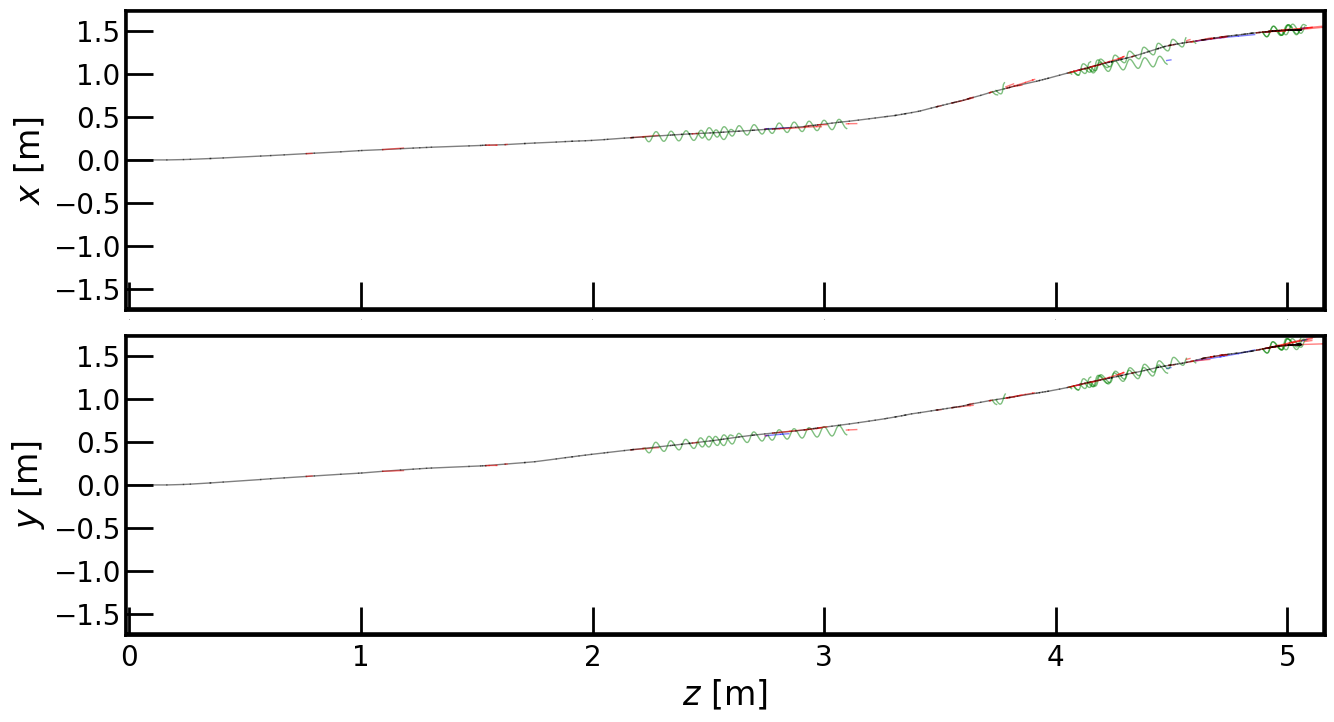

In [8]:
# We can also see the shower display for both graphite and lead
#fig, axes = event_display(muons_only[np.where(muon_energies > 0.025)])
fig, axes = event_display(s0)


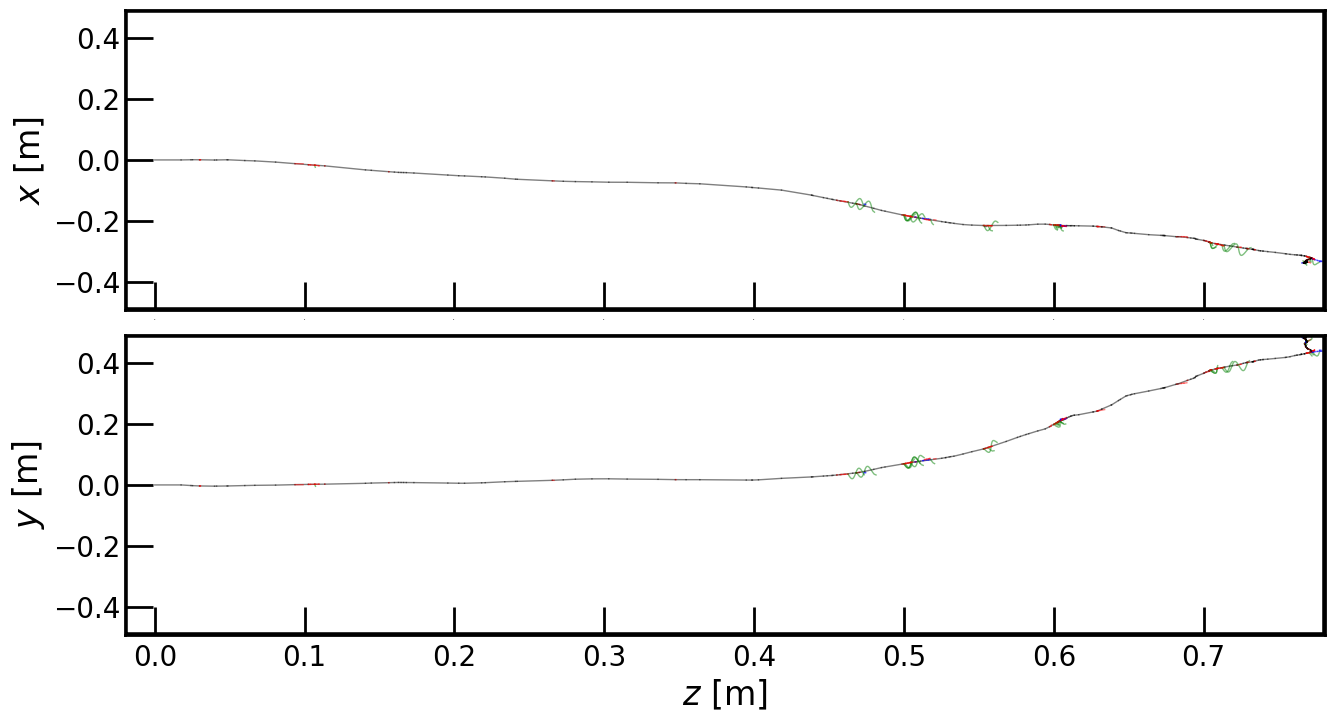

In [9]:
# We can also see the shower display for both graphite and lead
#fig, axes = event_display(muons_only_lead[np.where(muon_energies_lead > 1.0)])
fig, axes = event_display(s0L)